# GAIA Clustering and Get ilabel
#### -------------------------------------------------------------------------
## Data importation from **.vot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.cluster import DBSCAN
from sklearn import cluster

import sys, os
sys.path.append('C:\\Users\Quentin\\Documents\\ALMA_CHILI\\gaia-shock\\src')

## directory
rootdir = r'C:\Users\Quentin\Documents\ALMA_CHILI'
wdir    = r'%s\products'%(rootdir)
#notedir = r'%s\gaia-shock\notebooks_Quentin'%(rootdir)

os.chdir(wdir)  # to change the current directory

import gaia_utils_quentin as gu

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
voname_list = ["NGC2682-4.0deg-0.2err.vot", "NGC2516-3.5deg-0.2err.vot","NGC6811-1.0deg-0.2err.vot", "NGC1039-3.0deg-0.1err.vot",
               "Collinder65-4.0deg-0.2err.vot", "NGC1647-3.0deg-0.1err.vot"]

voname  = voname_list[1]
weight  = [5,1,1,4,4,4,4,4]
WEIGHT  = [10.7, 6.5, 6.5, 4.1, 4.1, 2.1, 2.1, 2.1]

with open('ilabel_dbscan', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    file_result = my_depickler.load()

In [3]:
source = gu.source()
source.read_votable(voname)
source.convert_filter_data()
source.convert_to_cartesian()
source.set_weight(weight)
source.normalization_normal()

## NGC2516-3.5deg-0.2err.vot read...
## Total stars: 45520
## Density star per pc^3: 0.02270

## Conversion done...
## Stars selected: 44723
## Normalization done on filtered data..


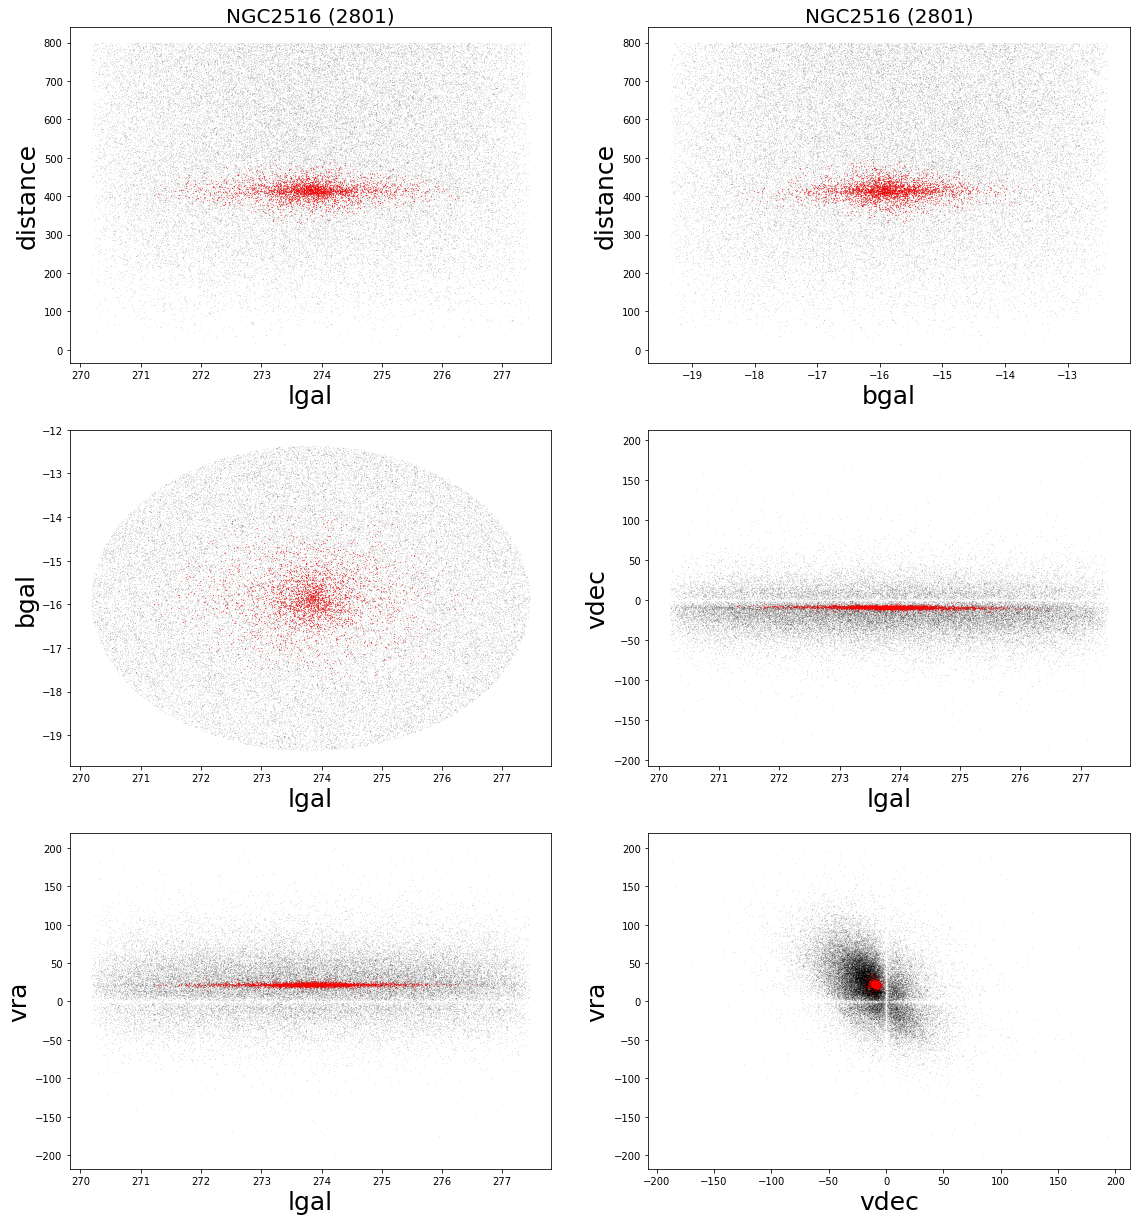

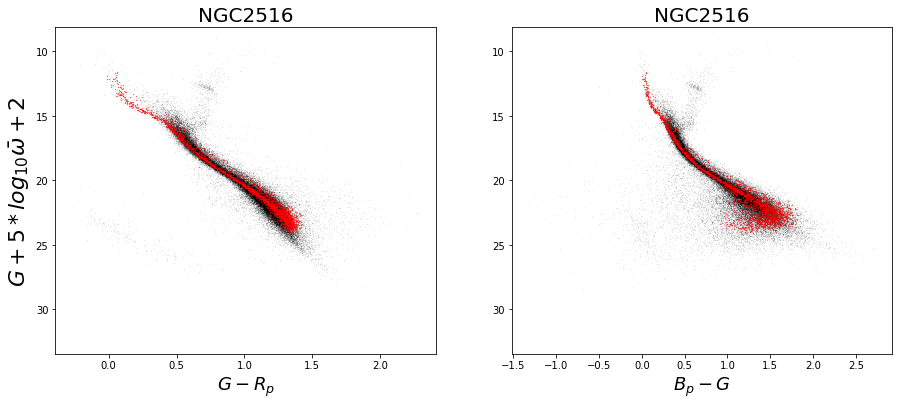

In [4]:
source.plot_information(0.001,False,ilabel=file_result[source.name]['ilabel'])

#### -------------------------------------------------------------------------

In [62]:
def save_ilabel(source, ilabel, eps, min_samples, version=1) :
    "Save ilabel found with dbscan(eps,min_samples,weight) from cluster 'source'"
    
    with open('ilabel_dbscan', 'rb') as fichier:
        my_depickler = pickle.Unpickler(fichier)
        file_result = my_depickler.load()
        
    # select data in cartesian from ilabel
    if source.dfcart is None :
        data_cart = gu.convert_to_cartesian(source.df[ilabel,:])
    else :
        data_cart = source.dfcart[ilabel,:]

    name = source.name
    if version != 1 :
        name = "%s_%d"%(name,version)
    
    
    if name not in file_result :
        file_result[name] = {}

    file_result[name] = {}
    file_result[name]['eps_min_samples'] = (eps,min_samples)
    file_result[name]['weight'] = source.weight
    file_result[name]['data_cart'] = data_cart
    file_result[name]['ilabel'] = ilabel
    file_result[name]['density'] = source.density

    with open('ilabel_dbscan', 'wb') as fichier:
        my_pickler = pickle.Pickler(fichier)
        my_pickler.dump(file_result)

In [43]:
##############################################
def dbscan_labels(data, eps=0.15, min_samples=15, all_labels=False, display=True) :
    "Compte a DBSCAN clustering and return the largest cluster found"

    ts = time.clock()
    db = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters_ > 0 :
        max_size = 0
        total_labels = []
        for i in range(n_clusters_) :
            ilabel = np.where(labels == i)[0]
            total_labels.append(ilabel)
            label_size = len(ilabel)
            if label_size > max_size :
                ilabel_final = np.copy(ilabel)
                max_size = label_size
        if all_labels : result = total_labels
        else          : result = ilabel_final
        if display :
            print("## %d clusters, size of the largest: %d  (on %d stars : %.1f%%)"%(n_clusters_,len(ilabel_final),len(data[:,1]),100*len(ilabel_final)/len(data[:,1])))
            tf = time.clock() - ts
            if tf//60 == 0 : string = "%.1fs"%(tf%60)
            else : string = "%dmin %.1fs"%(tf//60,tf%60)
            print("## Execution time : "+string)
        return result
    else :
        print("ERROR 0 cluster found with eps="+str(eps)+" and min_samples="+str(min_samples))
        return []


#### -------------------------------------------------------------------------
## DBSCAN Clustering

In [6]:
#save_ilabel(source,file_result_DAM[source.name]['ilabel'],file_result_DAM[source.name]['eps_min_samples'][0],file_result_DAM[source.name]['eps_min_samples'][1])

In [15]:
weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
WEIGHT  = [10.7, 6.5, 6.5, 4.1, 4.1, 2.1, 2.1, 2.1]
source.set_weight(weight)
source.normalization_normal()
#print(file_result["NGC2516"]['density'])
#print(source.density)

## Normalization done on filtered data..


In [19]:
print(file_result["NGC2516"]['eps_min_samples'])
print(source.distmax)

(1.4, 20)
800.0


In [55]:
eps=1.7
min_samples=20
ilabel_ = source.dbscan_labels(eps, min_samples, all_labels=True, display=True)
#save_ilabel(source, ilabel_[0], eps, min_samples)

## 1 clusters, size of the largest: 2801  (on 44723 stars : 6.3%)
## Execution time : 4.8s


In [50]:
for i, ilabel in enumerate(ilabel_):
    #a = np.zeros(source.df.shape[0])
    #a[ilabel] = 1
    #ii = np.where(a==0)[0]
    #gu.plot_information_cluster(source.dfcart[ii,:],size=0.01,cartesian=True)
    #gu.plot_information_cluster(source.dfcart,size=0.01,cartesian=True)
    print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

## 0, 2801 stars, Dist : 414.5, Max Dist : 165.9 and 39.4


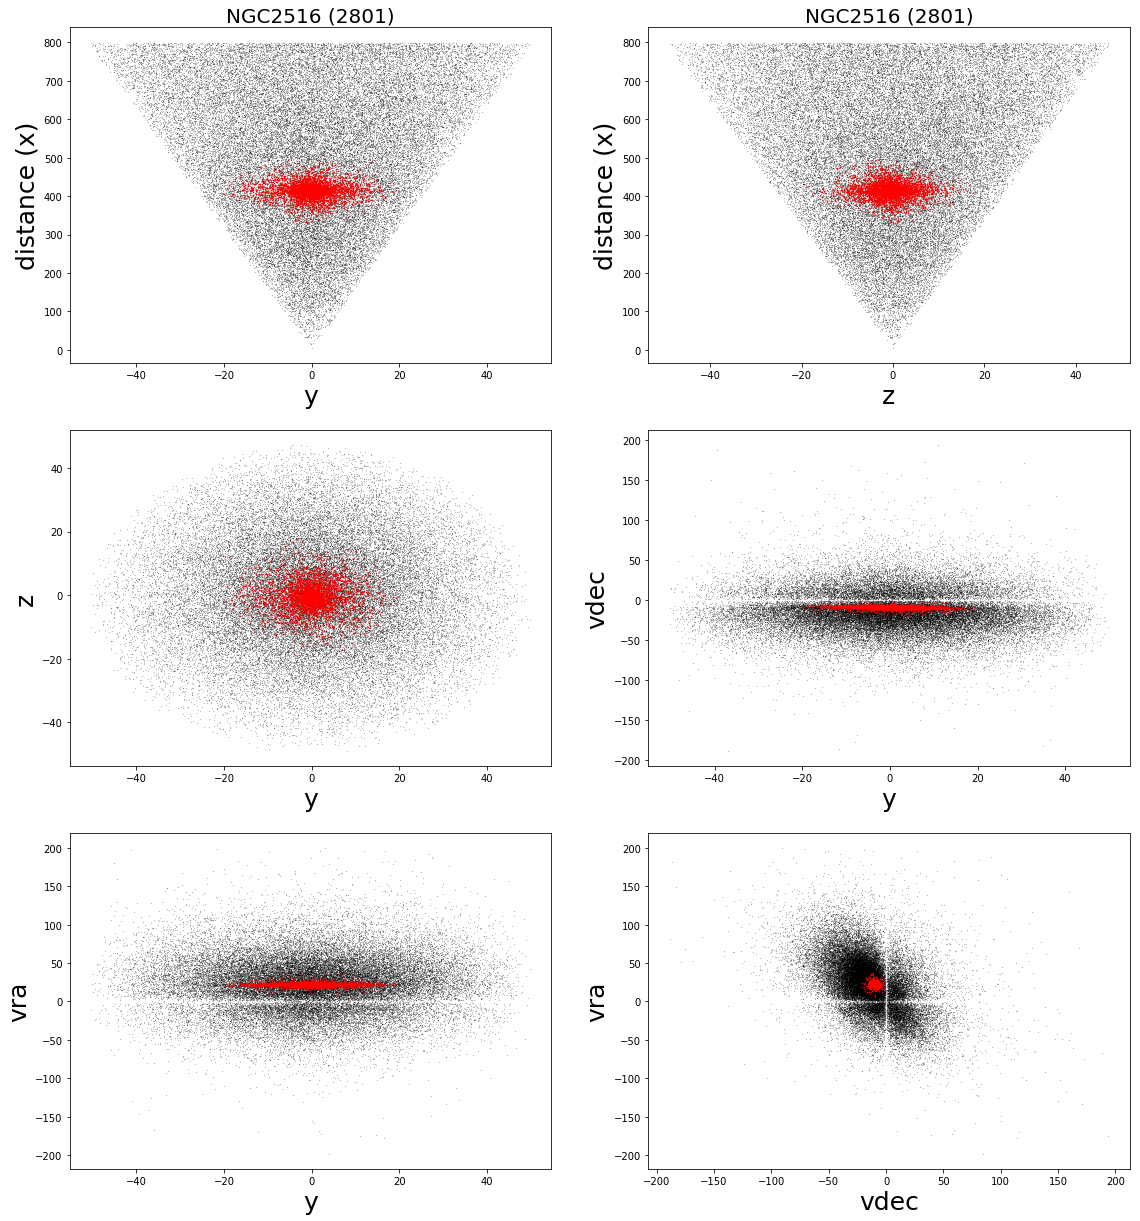

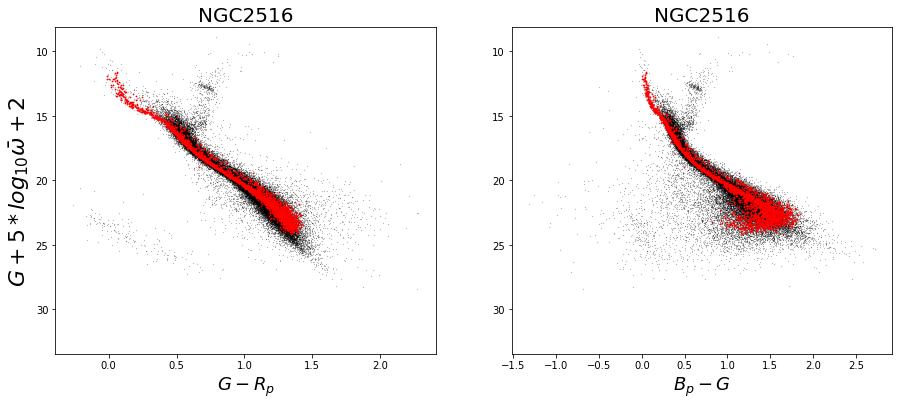

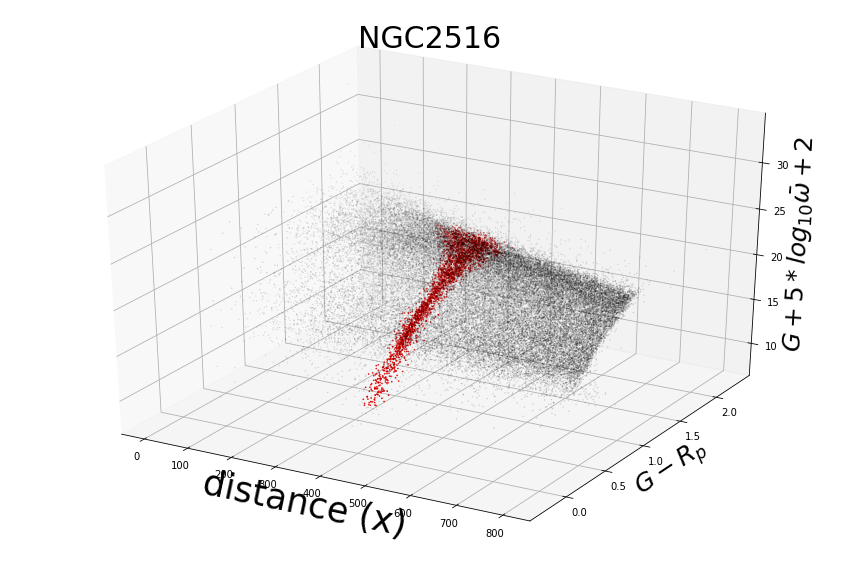

In [51]:
for ilabel in ilabel_ :
    #source.plot_information(0.1,False, HRD=False, ilabel=ilabel)
    source.plot_information(0.01,True, HRD=True, ilabel=ilabel)
    source.plot_3D(0.01,True,(0,6,5),ilabel=ilabel)

#### ------------------------------------------------------------------------
## Finding the best $eps$ and $min\_samples$

In [60]:
# #############################################################################
# Compute DBSCAN
ts = time.clock()
eps_ = [0.9,1.0,1.1,1.2,1.3,1.4,1.5]
min_samples_ = [10,15,20,25,30,40,50]
mat_nb_clusters = np.zeros((len(eps_),len(min_samples_)))
mat_max = np.zeros((len(eps_),len(min_samples_)))
for i in range(len(eps_)) :
    for j in range(len(min_samples_)) :
        db = DBSCAN(eps=eps_[i], min_samples=min_samples_[j]).fit(dfnormcart)
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        mat_nb_clusters[i,j] = n_clusters_
        max_label = 0
        for n in range(n_clusters_) :
            ilabel = np.where(labels == n)[0]
            if len(ilabel) > max_label :
                max_label = len(ilabel)
                #max_label = len(ilabel)/np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])
        mat_max[i,j] = max_label
        #print("Ok pour eps "+str(eps_[i])+" et min_samples="+str(min_samples_[j]))
tf = time.clock() - ts
if tf//60 == 0 : string = "%.1fs"%(tf%60)
else : string = "%dmin %.1fs"%(tf//60,tf%60)
print("## Execution time : "+string)

## Execution time : 1min 48.4s


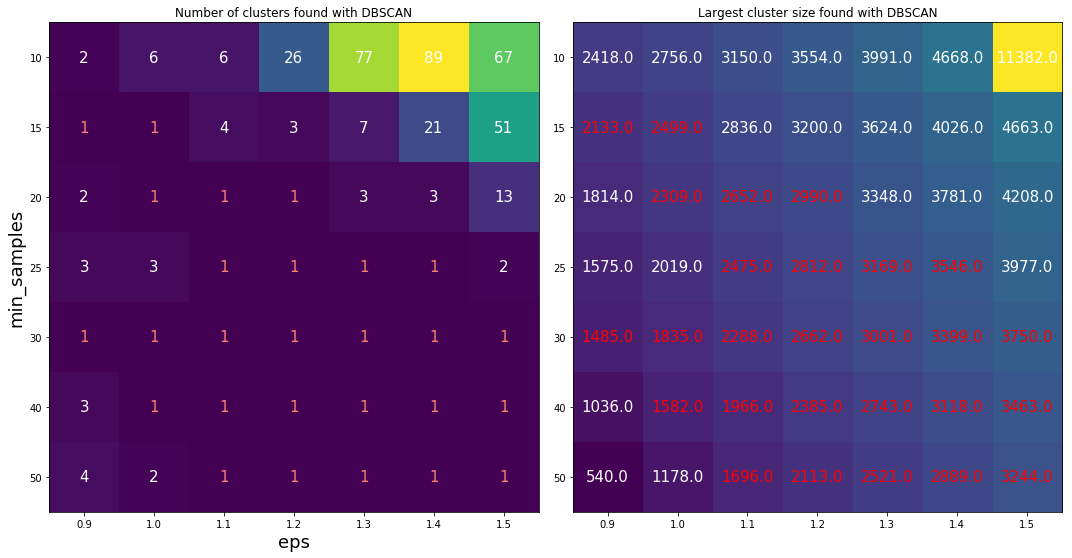

In [61]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(15,15))

im = ax.imshow(mat_nb_clusters.T)
ax.set_xticks(np.arange(len(eps_)))
ax.set_yticks(np.arange(len(min_samples_)))
ax.set_xticklabels(eps_)
ax.set_yticklabels(min_samples_)
# Loop over data dimensions and create text annotations.
for i in range(len(eps_)):
    for j in range(len(min_samples_)):
        if mat_nb_clusters[i, j] == 1 : color = "salmon"
        else : color = "w" 
        text = ax.text(i, j, '%d'%mat_nb_clusters[i, j],
                       ha="center", va="center", color=color, fontproperties='bold', fontsize=15)
ax.set_title("Number of clusters found with DBSCAN")
ax.set_xlabel("eps", fontsize = 18)
ax.set_ylabel("min_samples", fontsize = 18)
fig.tight_layout()

im = ax2.imshow(mat_max.T)
ax2.set_xticks(np.arange(len(eps_)))
ax2.set_yticks(np.arange(len(min_samples_)))
ax2.set_xticklabels(eps_)
ax2.set_yticklabels(min_samples_)
# Loop over data dimensions and create text annotations.
for i in range(len(eps_)):
    for j in range(len(min_samples_)):
        if mat_nb_clusters[i, j] == 1 : color = "r"
        else : color = "w" 
        text = ax2.text(i, j, '%.1f'%mat_max[i, j], ha="center", va="center", color=color, fontsize=15)
ax2.set_title("Largest cluster size found with DBSCAN")
ax.set_xlabel("eps", fontsize = 18)
ax.set_ylabel("min_samples", fontsize = 18)
fig.tight_layout()

plt.savefig('NGC6811_.png')
plt.show()

## -------------------------------------------------

In [35]:
a = []
for i in range(8) :
    dist = np.sort(source.dfcart[:,i])
    distm = dist[1:] - dist[:-1]
    a.append(np.mean(distm))
a = np.array(a)
print(a*1000)
print(1/a)
div = [15,8,0.5,0.07]

[17.77138526  2.23608783  2.14484967  8.54111145  8.88367166  0.56510687
  0.05700156  0.09026627]
[   56.27023361   447.20962409   466.23314264   117.08078108
   112.56606939  1769.57679594 17543.37859565 11078.33525286]


In [26]:
def lissage(x,y,p):
    "smoothing y data computing the Moving average"
    Lyout=[]; Lxout = np.copy(x[p: -p])
    for index in range(p, len(y)-p):
        Lyout.append(np.mean(y[index-p : index+p+1]))
    return Lxout,Lyout

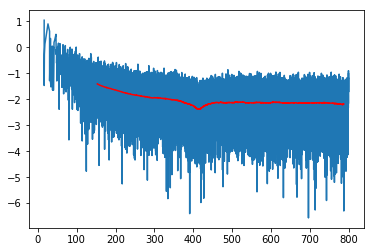

0.017771385255701093


In [32]:
dist = np.sort(source.dfcart[:,0])
distm = dist[1:] - dist[:-1]  
x, y = lissage(dist[1:],np.log10(distm), 1000)
plt.plot(dist[1:],np.log10(distm))
plt.plot(x,y,c='r')
plt.show()
print(np.mean(distm))

In [53]:
# Cartesian normalisation
# x, y, z must have the same importance, the same for vdec and vra // R-G and 
dfnormcart = np.zeros(source.df.shape)

weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
weight  = [1,1,1,1,1,1,1,1]
div = [15, 8, 0.5, 0.07]

for i, j in zip(range(source.df.shape[1]),[0,0,0,1,1,2,3,3]) :
    dfnormcart[:,i] = weight[i] * source.df[:,i] / div[j]

In [66]:
eps=1
min_samples=20
ilabel_ = dbscan_labels(dfnormcart,eps, min_samples, all_labels=True, display=True)
save_ilabel(source, ilabel_[0], eps, min_samples, version=2)

## 1 clusters, size of the largest: 2309  (on 44723 stars : 5.2%)
## Execution time : 1.7s


In [67]:
for i, ilabel in enumerate(ilabel_):
    #a = np.zeros(source.df.shape[0])
    #a[ilabel] = 1
    #ii = np.where(a==0)[0]
    #gu.plot_information_cluster(source.dfcart[ii,:],size=0.01,cartesian=True)
    #gu.plot_information_cluster(source.dfcart,size=0.01,cartesian=True)
    print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

## 0, 2309 stars, Dist : 413.2, Max Dist : 108.5 and 52.1


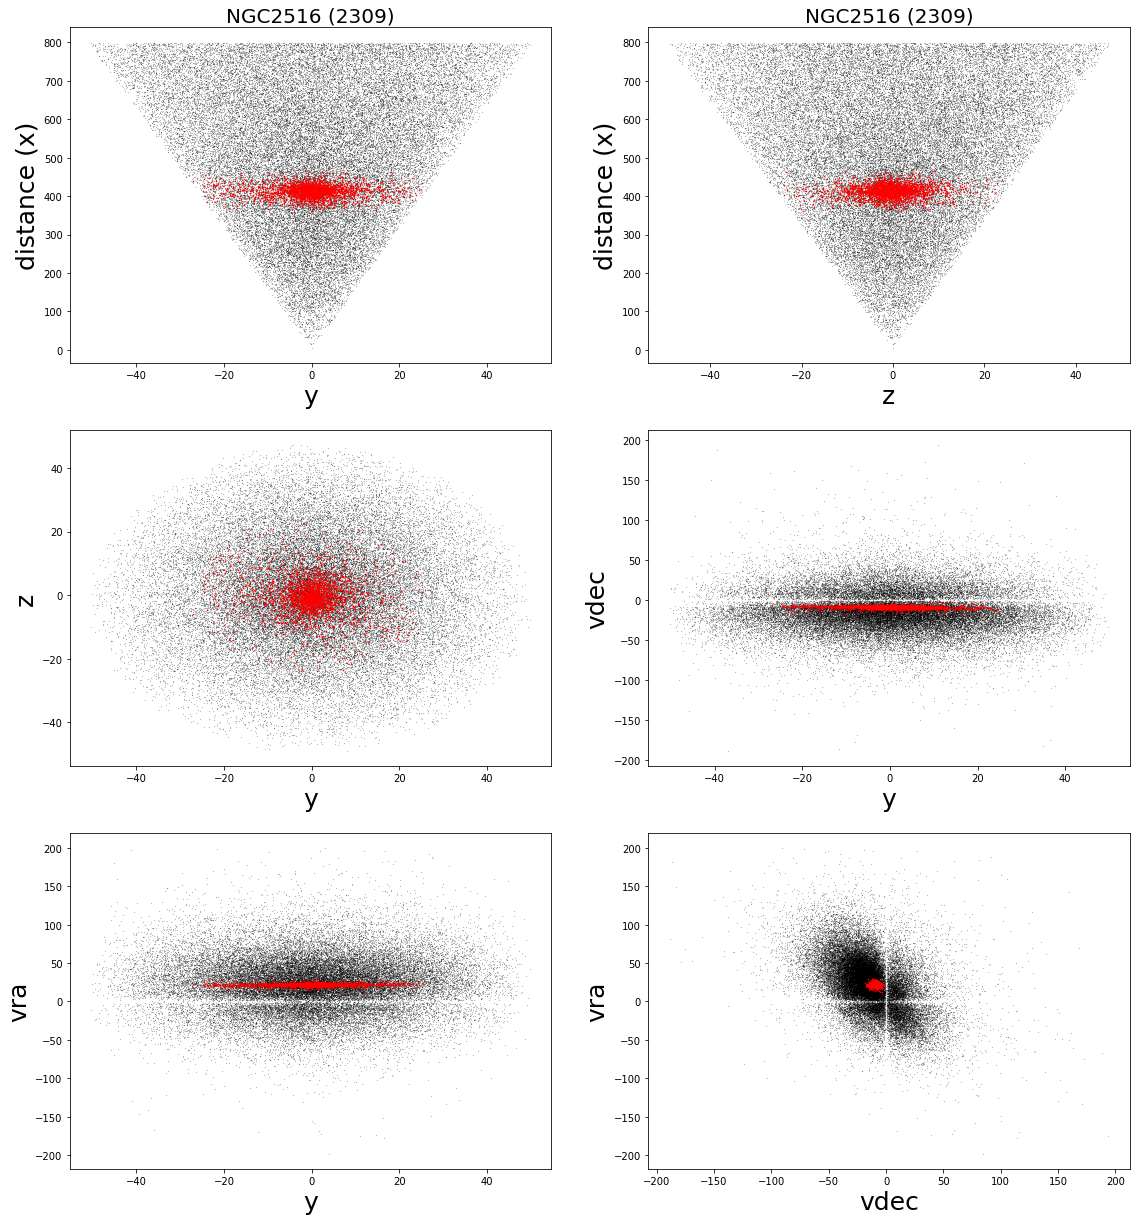

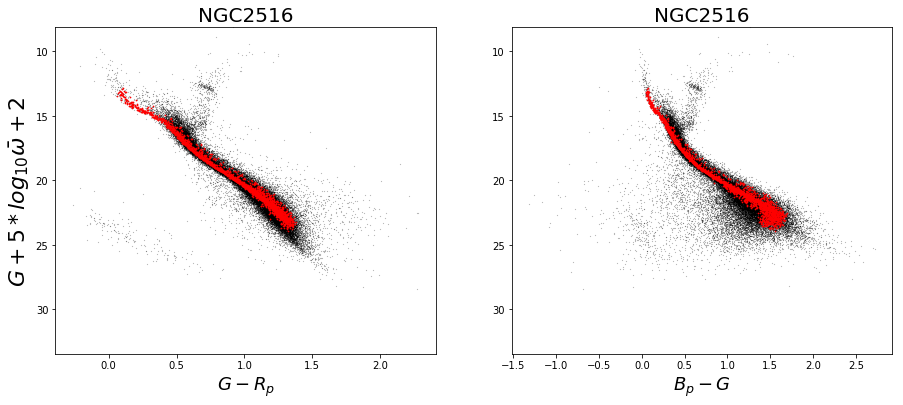

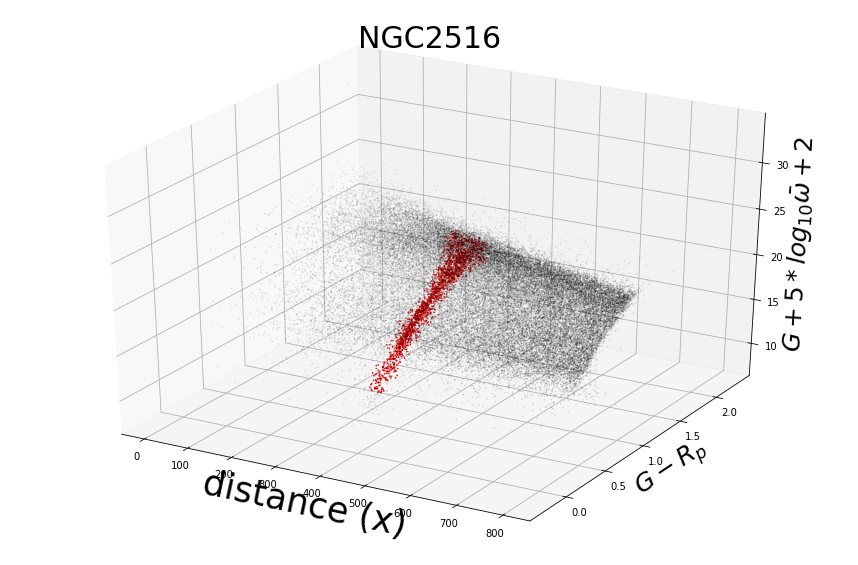

In [68]:
for ilabel in ilabel_ :
    #source.plot_information(0.1,False, HRD=False, ilabel=ilabel)
    source.plot_information(0.01,True, HRD=True, ilabel=ilabel)
    source.plot_3D(0.01,True,(0,6,5),ilabel=ilabel)